In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import emcee 
import pyimfit 
from astropy.io import fits
import corner
from IPython.display import Latex
import sys
import warnings
import tqdm
import pathlib
import pickle

plt.rcParams['image.cmap'] = 'Blues'
warnings.filterwarnings("ignore")

imageFile = "agn.fits"
imageAGN = fits.getdata(imageFile)

epsf = fits.getdata("../psfConstruction/epsf2.fits")
epsf_star = fits.getdata("../psfConstruction/star0.fits")

In [3]:
def find_highest_indices(arr):
    flattened_arr = np.array(arr).flatten()
    max_indices = np.unravel_index(np.argsort(flattened_arr)[-2:], arr.shape)
    return max_indices


def galaxy_model(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, Xlim, Ylim,
                 PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                 PA_lim, ell_lim, I_lim, sigma_lim, Iss_lim, rss_lim):
    """create galaxy model for ML fit
        including: ps: 1 psf + 1 sersic
                   psps: 2 psf + 2 sersic"""

    sersic = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell_bulge': [ell_ss, ell_lim[0],ell_lim[1]], 'n': [n_ss, 'fixed'],
    'I_e': [I_ss, Iss_lim[0],Iss_lim[1]], 'r_e': [r_ss, rss_lim[0],rss_lim[1]]}
    sersic_dict = {'name': "Sersic", 'label': "bulge", 'parameters': sersic}
    
    psf = {'I_tot' : Itot}
    psf_dict = {'name': "PointSource", 'label': "psf", 'parameters': psf}

    funcset_dict_psf0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    funcset_dict_psf1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    funcset_dict_sersic0 = {'X0': [Xss0,Xlim[0],Xlim[1]], 'Y0': [Yss0,Ylim[0],Ylim[1]], 
                   'function_list': [sersic_dict]}
    funcset_dict_sersic1 = {'X0': [Xss1,Xlim[0],Xlim[1]], 'Y0': [Yss1,Ylim[0],Ylim[1]], 
                   'function_list': [sersic_dict]}
    
    funcset_dict_psfser0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict, sersic_dict]}
    funcset_dict_psfser1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict, sersic_dict]}

    
    model_dict_ps_1c = {'function_sets': [funcset_dict_psfser0]}
    model_dict_psps_1c = {'function_sets': [funcset_dict_psfser0,funcset_dict_psfser1]}
    
    model_dict_ps_2c = {'function_sets': [funcset_dict_psf0,funcset_dict_sersic0]}
    model_dict_psps_2c = {'function_sets': [funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_sersic1]}
    
    model_ps1c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_ps_1c)
    model_psps1c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_psps_1c)
    model_ps2c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_ps_2c)
    model_psps2c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_psps_2c)
    return model_ps1c, model_psps1c, model_ps2c, model_psps2c



def doFit(models,epsf): 
    """do fit with data using PSF oversampled by factor of 4 over whole image
       return fitters"""
    fitters = []
    # oversamped PSF
    psfOsamp = pyimfit.MakePsfOversampler(epsf, 4, (0,100,0,100))
    osampleList = [psfOsamp]
    for i in tqdm.tqdm(range(len(models)), desc="Fitting Models"):
        imfit_fitter = pyimfit.Imfit(models[i],psf=epsf)
        imfit_fitter.loadData(imageAGN, psf_oversampling_list=osampleList, gain=9.942e-1, read_noise=0.22, original_sky=15.683)
        imfit_fitter.doFit()
        fitters.append(imfit_fitter)
    return fitters


def plot_bestFit(fitters, imageAGN, title,filename,suptit):
    """plot and save bestfit images"""
    fig, ax = plt.subplots(len(fitters), 3,figsize=(12,16))
    for i in range(len(title)):
        im0 = ax[i,0].imshow(fitters[i].getModelImage())
        ax[i,0].set_title(title[i], fontweight='bold')

        im1 = ax[i,1].imshow(imageAGN-fitters[i].getModelImage())
        ax[i,1].set_title("residual")

        im2 = ax[i,2].imshow(imageAGN)
        ax[i,2].set_title("data")

        # Create a colorbar for each axis
        for j, im in zip(np.arange(3), [im0,im1,im2]):
            cbar = fig.colorbar(im, ax=ax[i,j], shrink=0.6)

        # Set the same colorbar scale for both axes
        vmin = min(im0.get_array().min(), im2.get_array().min())
        vmax = max(im0.get_array().max(), im2.get_array().max())
        [im.set_clim(vmin, vmax) for im in [im0,im2]]
    
    fig.suptitle(suptit)
    fig.tight_layout()
    fig.savefig(filename)
    
            

def saveBestfits(fitters,models, fn):
    keys = ['fit1_1c','fit2_1c','fit1_2c','fit2_2c']
    data_to_save = {}
    for key, i in zip(keys,range(4)):
        data_to_save[key] = fitters[i].getFitResult().params
        data_to_save[key+'_fitConfig'] = models[i]
    with open(fn, 'wb') as file:
        pickle.dump(data_to_save, file)

In [4]:
starpos = find_highest_indices(imageAGN)
center = (starpos[0]+starpos[1])/2
Imax = imageAGN.max()
itot=130
print(itot)

#create galaxy models with n=1
model_ps_n1c1, model_psps_n1c1, model_ps_n1c2, model_psps_n1c2 = galaxy_model(X0=starpos[0][0], Y0=starpos[0][1], X1=starpos[1][0], Y1=starpos[1][1], 
                                                 Xss0=starpos[0][0], Yss0=starpos[0][1], Xss1=starpos[1][0], Yss1=starpos[1][1],
                                                 Xlim=[0,100], Ylim=[0,100],
                                                 PA_ss=200, ell_ss=0.1, n_ss=1, I_ss=1, r_ss=20, Itot=itot,
                                                 PA_lim=[0,360], ell_lim=[0.0,1.0], I_lim=[0,Imax], sigma_lim=[0,15],
                                      Iss_lim=[0,Imax], rss_lim=[0,100])

#create galaxy models with n=4
model_ps_n4c1, model_psps_n4c1, model_ps_n4c2, model_psps_n4c2 = galaxy_model(X0=starpos[0][0], Y0=starpos[0][1], X1=starpos[1][0], Y1=starpos[1][1], 
                                                 Xss0=starpos[0][0], Yss0=starpos[0][1], Xss1=starpos[1][0], Yss1=starpos[1][1],
                                                 Xlim=[0,100], Ylim=[0,100],
                                                 PA_ss=200, ell_ss=0.1, n_ss=4, I_ss=1, r_ss=20, Itot=itot,
                                                 PA_lim=[0,360], ell_lim=[0.0,1.0], I_lim=[0,Imax], sigma_lim=[0,15],
                                      Iss_lim=[0,Imax], rss_lim=[0,100])


130


# fit psf star

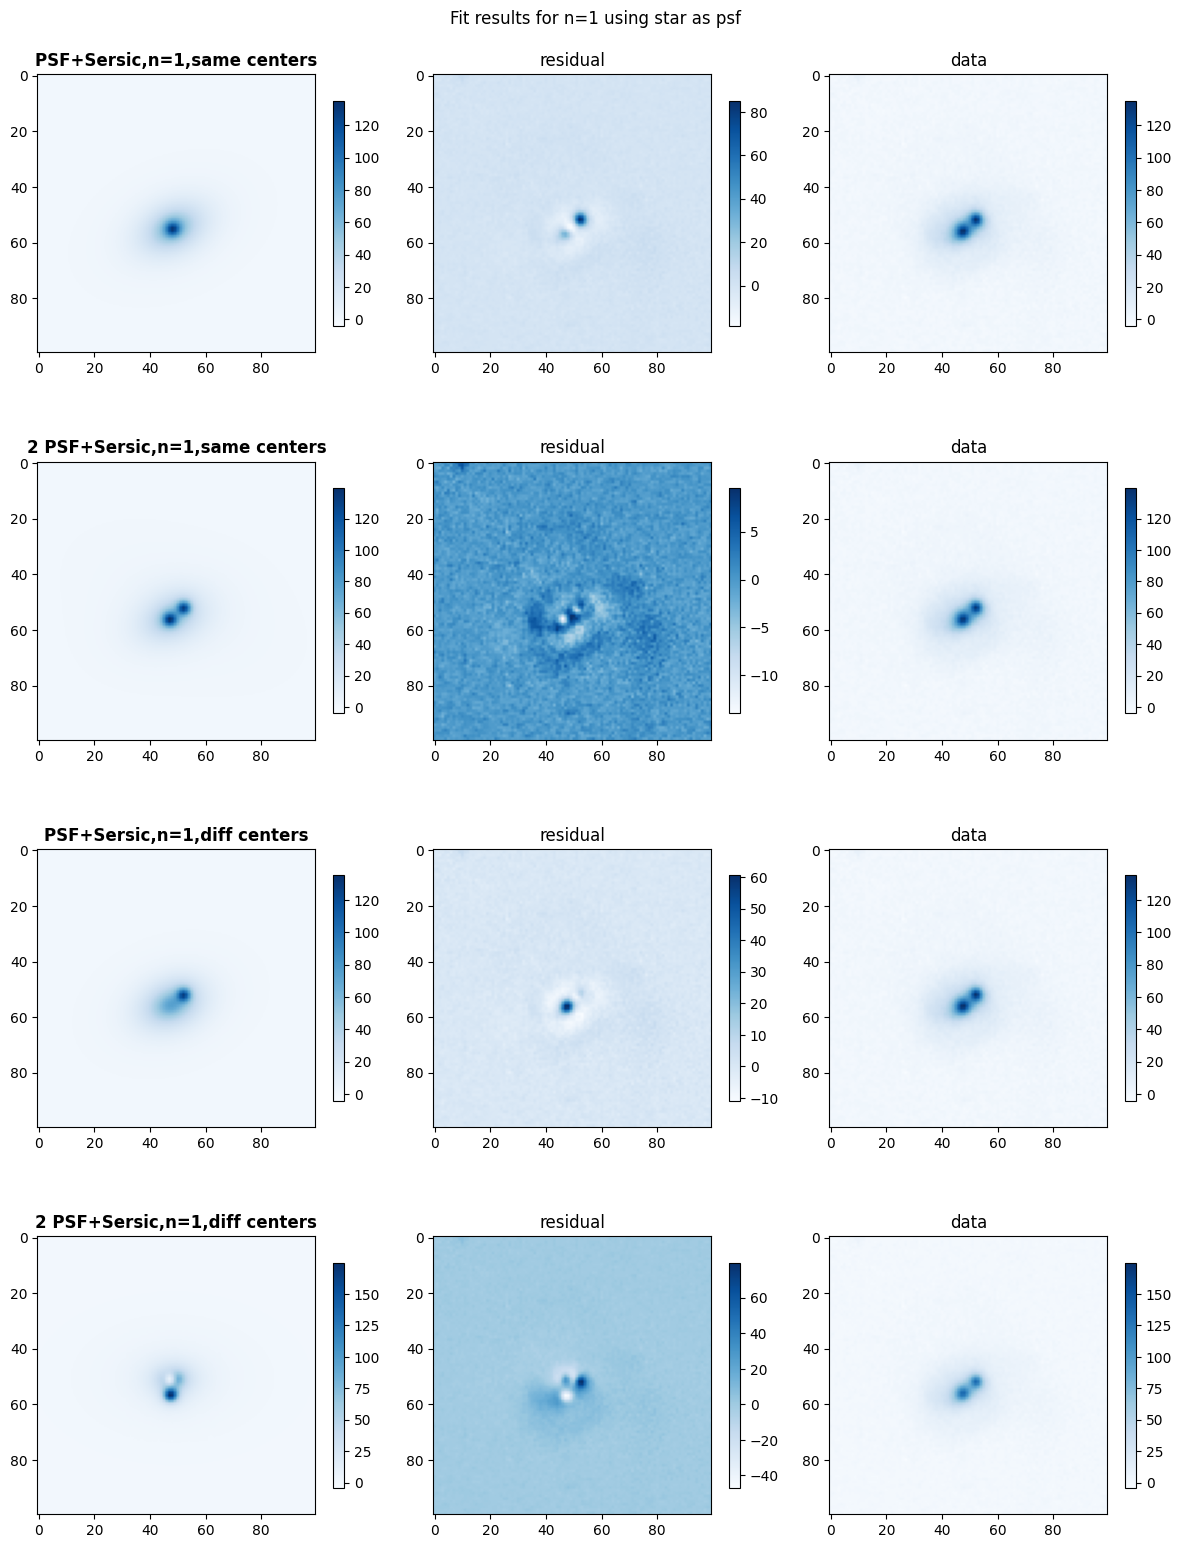

In [19]:
# FITTING
def doFit_star(models,epsf): 
    """do fit and return fitters, best fit params, and labels"""
    fitters = []
    for i in range(len(models)):
        imfit_fitter = pyimfit.Imfit(models[i],psf=epsf)
        imfit_fitter.loadData(imageAGN, gain=9.942e-1, read_noise=0.22, original_sky=15.683)
        imfit_fitter.doFit()
        fitters.append(imfit_fitter)
    return fitters

models_n1 = [model_ps_n1c1, model_psps_n1c1, model_ps_n1c2, model_psps_n1c2]
fitters_n1 = doFit_star(models_n1,epsf_star)
title_n1 = ["PSF+Sersic,n=1,same centers","2 PSF+Sersic,n=1,same centers",
         "PSF+Sersic,n=1,diff centers","2 PSF+Sersic,n=1,diff centers"]
plot_bestFit(fitters_n1, imageAGN, title_n1,"fit_star_n1_90.jpg","Fit results for n=1 using star as psf")
save_config_bestfit(title_n1, models_n1, fitters_n1, "fit_star_n1_90.txt")

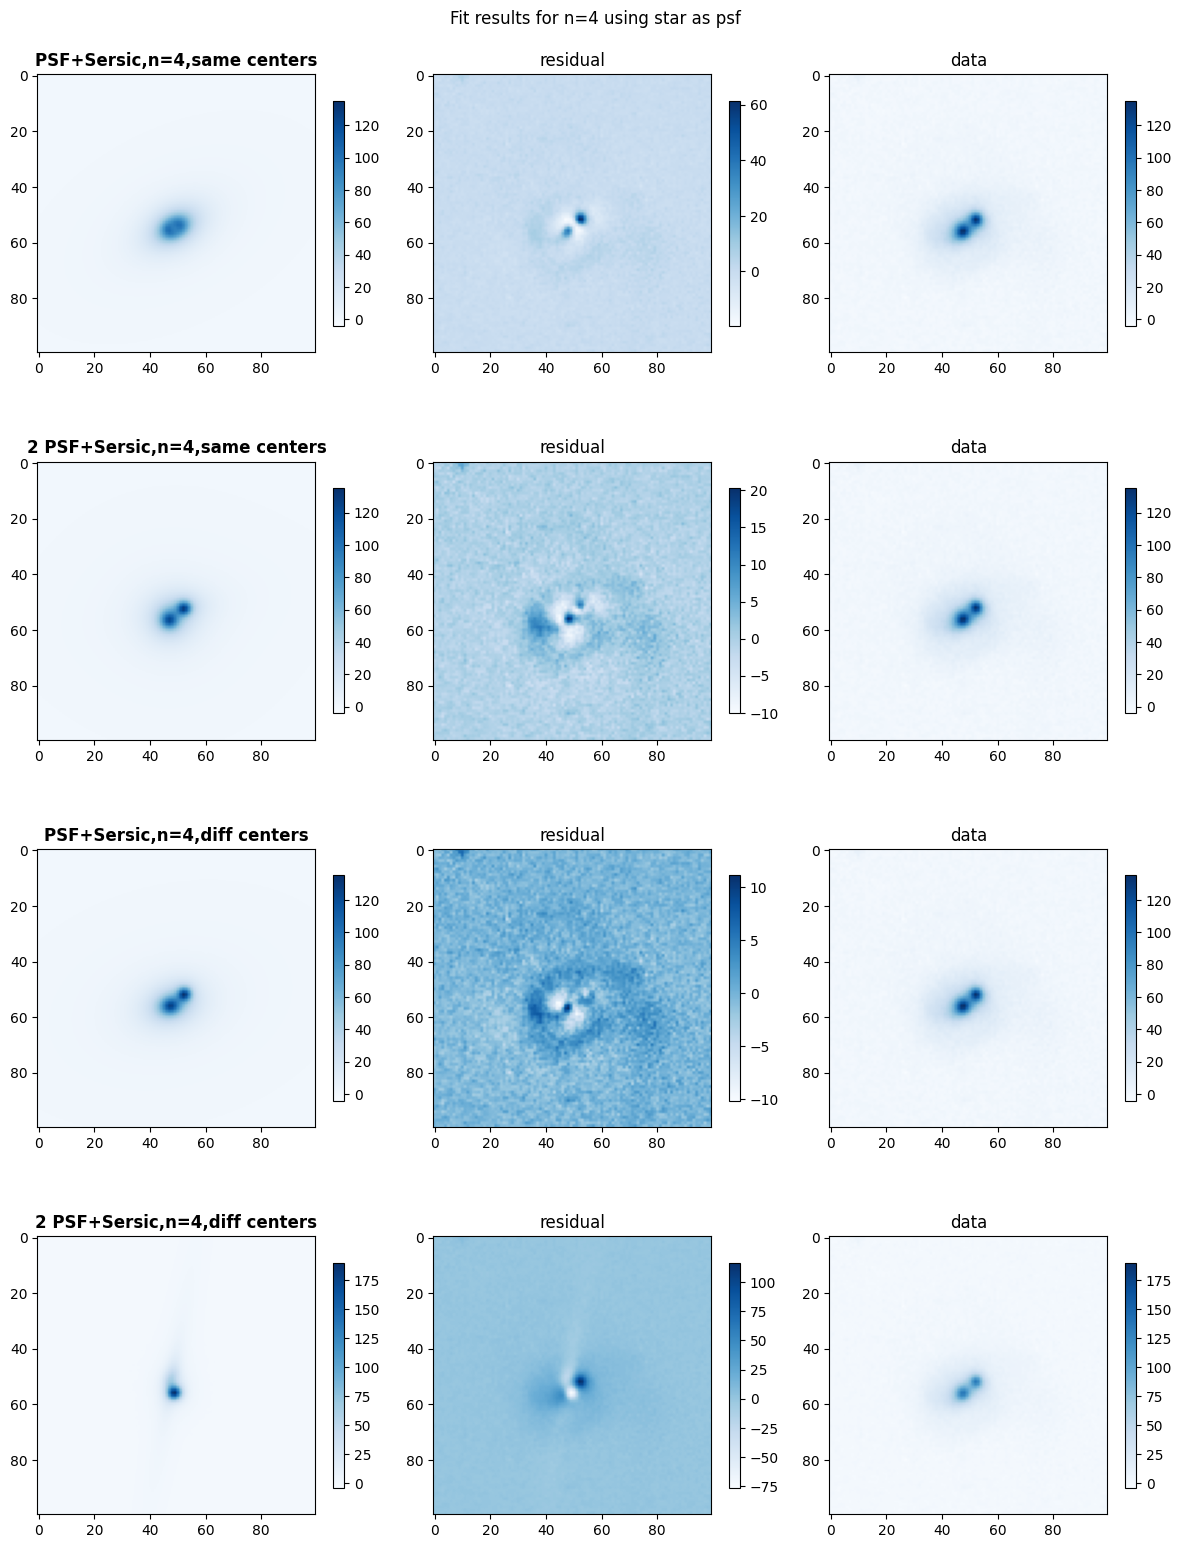

In [22]:
models_n4 = [model_ps_n4c1, model_psps_n4c1, model_ps_n4c2, model_psps_n4c2]
fitters_n4 = doFit_star(models_n4,epsf_star)
title_n4 = ["PSF+Sersic,n=4,same centers","2 PSF+Sersic,n=4,same centers",
         "PSF+Sersic,n=4,diff centers","2 PSF+Sersic,n=4,diff centers"]
plot_bestFit(fitters_n4, imageAGN, title_n4,"fit_star_n4_130.jpg","Fit results for n=4 using star as psf")
save_config_bestfit(title_n4, models_n4, fitters_n4, "fit_star_n4_130.txt")

# fit epsf

In [6]:
models_n1 = [model_ps_n1c1, model_psps_n1c1, model_ps_n1c2, model_psps_n1c2]
fitters_n1 = doFit(models_n1,epsf)
title_n1 = ["PSF+Sersic,n=1,same centers","2 PSF+Sersic,n=1,same centers",
         "PSF+Sersic,n=1,diff centers","2 PSF+Sersic,n=1,diff centers"]
#plot_bestFit(fitters_n1, imageAGN, title_n1,"fit_n1.jpg","Fit results for n=1 using ePSF")
#save_config_bestfit(title_n1, models_n1, fitters_n1, "fit_n1.txt")


models_n4 = [model_ps_n4c1, model_psps_n4c1, model_ps_n4c2, model_psps_n4c2]
fitters_n4 = doFit(models_n4,epsf)
title_n4 = ["PSF+Sersic,n=4,same centers","2 PSF+Sersic,n=4,same centers",
         "PSF+Sersic,n=4,diff centers","2 PSF+Sersic,n=4,diff centers"]
#plot_bestFit(fitters_n4, imageAGN, title_n4,"fit_n4.jpg", "Fit results for n=1 using ePSF")
#save_config_bestfit(title_n4, models_n4, fitters_n4, "fit_n4.txt")

PsfOversampling: starting initialization...
141
PsfOversampling: done.


Fitting Models: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [03:01<00:00, 45.48s/it]

PsfOversampling: starting __dealloc__.
PsfOversampling: done with __dealloc__.
PsfOversampling: starting initialization...
141
PsfOversampling: done.



Fitting Models: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [03:46<00:00, 56.56s/it]

PsfOversampling: starting __dealloc__.
PsfOversampling: done with __dealloc__.


Text(0.5, 0.98, '1D profiles for 2 PSF + sersic fit vs data, n=1')

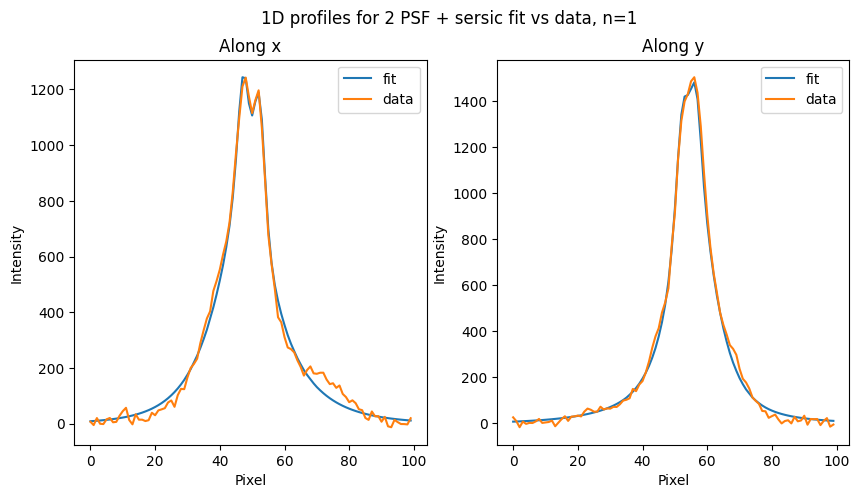

In [5]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
tit = ["Along x", "Along y"]
for i in range(2):
    xsum = np.sum(fitters_n1[1].getModelImage(),axis=i)
    xsumIm = np.sum(imageAGN, axis=i)
    ax[i].plot(np.arange(len(xsum)), xsum, label="fit")
    ax[i].plot(np.arange(len(xsumIm)), xsumIm, label="data")
    ax[i].set_title(tit[i])
    ax[i].set_xlabel("Pixel")
    ax[i].set_ylabel("Intensity")
    ax[i].legend()
fig.suptitle("1D profiles for 2 PSF + sersic fit vs data, n=1")


Text(0.5, 0.98, '1D profiles for 2 PSF + sersic fit vs data, n=4')

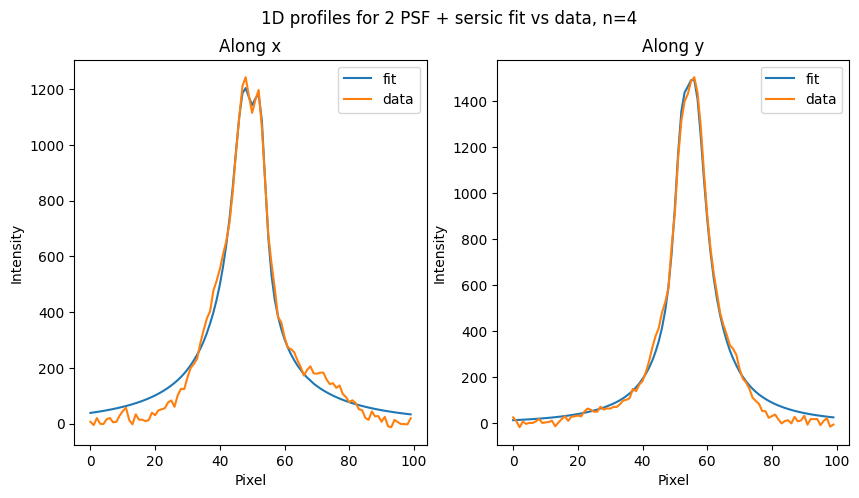

In [49]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
tit = ["Along x", "Along y"]
for i in range(2):
    xsum = np.sum(fitters_n4[1].getModelImage(),axis=i)
    xsumIm = np.sum(imageAGN, axis=i)
    ax[i].plot(np.arange(len(xsum)), xsum, label="fit")
    ax[i].plot(np.arange(len(xsumIm)), xsumIm, label="data")
    ax[i].set_title(tit[i])
    ax[i].set_xlabel("Pixel")
    ax[i].set_ylabel("Intensity")
    ax[i].legend()
fig.suptitle("1D profiles for 2 PSF + sersic fit vs data, n=4")

# MCMC

def lnPosterior_for_emcee( params, imfitter, lnPrior_func ):
    lnPrior = lnPrior_func(params, imfitter)
    if not np.isfinite(lnPrior):
        return -np.inf
    # note that Imfit.computeFitStatistic returns -2 log(likelihood)
    lnLikelihood = -0.5 * imfitter.computeFitStatistic(params)
    return lnPrior + lnLikelihood


def lnPrior_limits( params, imfitter ):
    parameterLimits = imfitter.getParameterLimits()
    #if None in parameterLimits:
    #    raise ValueError("All parameters must have lower and upper limits.")
    nParams = len(params)
    for i in range(nParams):
        if parameterLimits[i]!=None:
        ## if param value is outside of the limits set by the model
            if params[i] < parameterLimits[i][0] or params[i] > parameterLimits[i][1]:
                return -np.inf
    return 0.0


    
def run_mcmc(p_bestfit, imfit_fitter, chainlen,paras, rand_ini=1e-4):
    ndims, nwalkers = len(p_bestfit), 100
    sampler = emcee.EnsembleSampler(nwalkers, ndims, lnPosterior_for_emcee,parameter_names=paras, args=(imfit_fitter, lnPrior_limits))
    #inital position around best fit
    initial_pos = [p_bestfit + rand_ini*np.random.randn(ndims) for i in range(nwalkers)]
    sampler.reset()
    final_state = sampler.run_mcmc(initial_pos, chainlen,progress=True)
    return sampler




In [3]:
def lnPrior_limits(params, imfitter):
    """calculate prior for parameters that are not n=1"""
    parameterLimits = imfitter.getParameterLimits()
    parameterLimits[2] = (0,10000)
    del parameterLimits[5]
    nParams = len(params)
    for i in range(nParams):
        #print(params[i], parameterLimits[i])
        #if parameterLimits[i] != None:   
        ## if param value is outside of the limits set by the model
        if params[i] < parameterLimits[i][0] or params[i] > parameterLimits[i][1]:
            return -np.inf
    return 0.0


def lnPosterior_for_emcee(params, imfitter, lnPrior_func):
    lnPrior = lnPrior_func(params, imfitter)
    if not np.isfinite(lnPrior):
        return -np.inf
    #put back n=1 to calculate likelihood
    params = np.insert(params,5,1)
    # note that Imfit.computeFitStatistic returns -2 log(likelihood)
    lnLikelihood = -0.5 * imfitter.computeFitStatistic(params)
    return lnPrior + lnLikelihood

    
def runMCMC(p_bestfit, imfit_fitter, chainlen,rand_ini=1e-4):
    # less 1 dimension of n
    ndims, nwalkers = len(p_bestfit)-1, 100
    sampler = emcee.EnsembleSampler(nwalkers, ndims, lnPosterior_for_emcee,args=(imfit_fitter, lnPrior_limits))
    #inital position around best fit
    initial_pos = [p_bestfit + rand_ini*np.random.randn(ndims) for i in range(nwalkers)]
    sampler.reset()
    final_state = sampler.run_mcmc(initial_pos, chainlen,progress=True)
    return sampler

In [6]:
def getFits():
    """get fitters and best fit values"""
    with open('fitResults/J1215+1344_fit_.pkl', 'rb') as file:
        d = pickle.load(file)
    # get model to create fitters
    models_n1 = d['fitConfig_n1']
    models_n4 = d['fitConfig_n4']
    psfOsamp = pyimfit.MakePsfOversampler(epsf, 4, (0,100,0,100))
    osampleList = [psfOsamp]
    fitters_n1, fitters_n4 =[], []
    for fitters, models in zip([fitters_n1, fitters_n4],[models_n1,models_n4]):
        for i in tqdm.tqdm(range(len(models)), desc="Fitting Models"):
            imfit_fitter = pyimfit.Imfit(models[i],psf=epsf)
            imfit_fitter.loadData(imageAGN, psf_oversampling_list=osampleList, gain=9.942e-1, read_noise=0.22, original_sky=15.683)
            fitters.append(imfit_fitter)
    return fitters_n1, fitters_n4, d['bestfit_n1'], d['bestfit_n4']

fitters_n1, fitters_n4, bestfits_n1, bestfits_n4 = getFits()

PsfOversampling: starting initialization...
141
PsfOversampling: done.


Fitting Models: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.30it/s]

PsfOversampling: starting __dealloc__.
PsfOversampling: done with __dealloc__.


In [89]:
def lnPosterior_for_emcee(params, imfitter,p_bestfit,rmInd):
    parameterLimits = imfitter.getParameterLimits()
    parameterLimits = [element for index, element in enumerate(parameterLimits) if index not in rmInd]
    parameterLimits = [(0,100000) if e is None else e for e in parameterLimits]
    nParams = len(params)
    for i in range(nParams):
        if params[i] < parameterLimits[i][0] or params[i] > parameterLimits[i][1]:
            lnPrior =  -np.inf
        else:
            lnPrior = 0.0
    if not np.isfinite(lnPrior):
        return -np.inf
    #put back n=1 to calculate likelihood
    params = np.insert(p_bestfit,rmInd,1)
    # note that Imfit.computeFitStatistic returns -2 log(likelihood)
    lnLikelihood = -0.5 * imfitter.computeFitStatistic(params)
    return lnPrior + lnLikelihood


def run_emcee(p_bestfit, fitter,rmInd):
    p_bestfit = np.delete(p_bestfit, rmInd)
    ndims, nwalkers = len(p_bestfit), 50
    initial_pos = [p_bestfit + 0.001*np.random.randn(ndims) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndims, lnPosterior_for_emcee, args=(fitter,p_bestfit,rmInd))
    sampler.reset()
    final_state = sampler.run_mcmc(initial_pos,2,progress=True)
    return sampler

In [92]:
rmInd = [[5],[5,13],[6],[11,18]]
samplers = []
for i in range(4):
    samplers.append(run_emcee(bestfits_n1[i],fitters_n1[i],rmInd[i]))

100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:40<00:00, 20.00s/it]


In [126]:
with open('test.pkl', 'rb') as file:
    c = pickle.load(file)

In [125]:
chains = [sampler.chain for sampler in samplers]
with open('test.pkl', 'wb') as file:
    pickle.dump(chains,file)

In [127]:
c[3].shape

(50, 2, 18)

In [28]:
import cProfile
def main():
    # Your main code here
    p_bestfit = fitters_n1[0].getFitResult().params
    p_bestfit = np.delete(p_bestfit, 5)
    ndims, nwalkers = len(p_bestfit), 50
    initial_pos = [p_bestfit + 0.001*np.random.randn(ndims) for i in range(nwalkers)]


    sampler = emcee.EnsembleSampler(nwalkers, ndims, lnPosterior_for_emcee, args=(fitters_n1[0], lnPrior_limits))
    sampler.reset()
    final_state = sampler.run_mcmc(initial_pos,2,progress=True)
    

cProfile.run("main()", sort="cumulative")

100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.25s/it]

         13178 function calls (13027 primitive calls) in 42.688 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   42.688   42.688 {built-in method builtins.exec}
        1    0.000    0.000   42.688   42.688 <string>:1(<module>)
        1    0.000    0.000   42.688   42.688 3270758329.py:1(main)
        1    0.000    0.000   42.683   42.683 ensemble.py:419(run_mcmc)
        3    0.000    0.000   42.683   14.228 ensemble.py:251(sample)
        5    0.003    0.001   42.665    8.533 ensemble.py:451(compute_log_prob)
      150    0.002    0.000   42.662    0.284 ensemble.py:622(__call__)
      150    0.008    0.000   42.660    0.284 4032129751.py:16(lnPosterior_for_emcee)
      150    0.022    0.000   42.616    0.284 fitting.py:664(computeFitStatistic)
      150   42.594    0.284   42.594    0.284 {method 'computeFitStatistic' of 'pyimfit.pyimfit_lib.ModelObjectWrapper' objects}
        2    0.001 

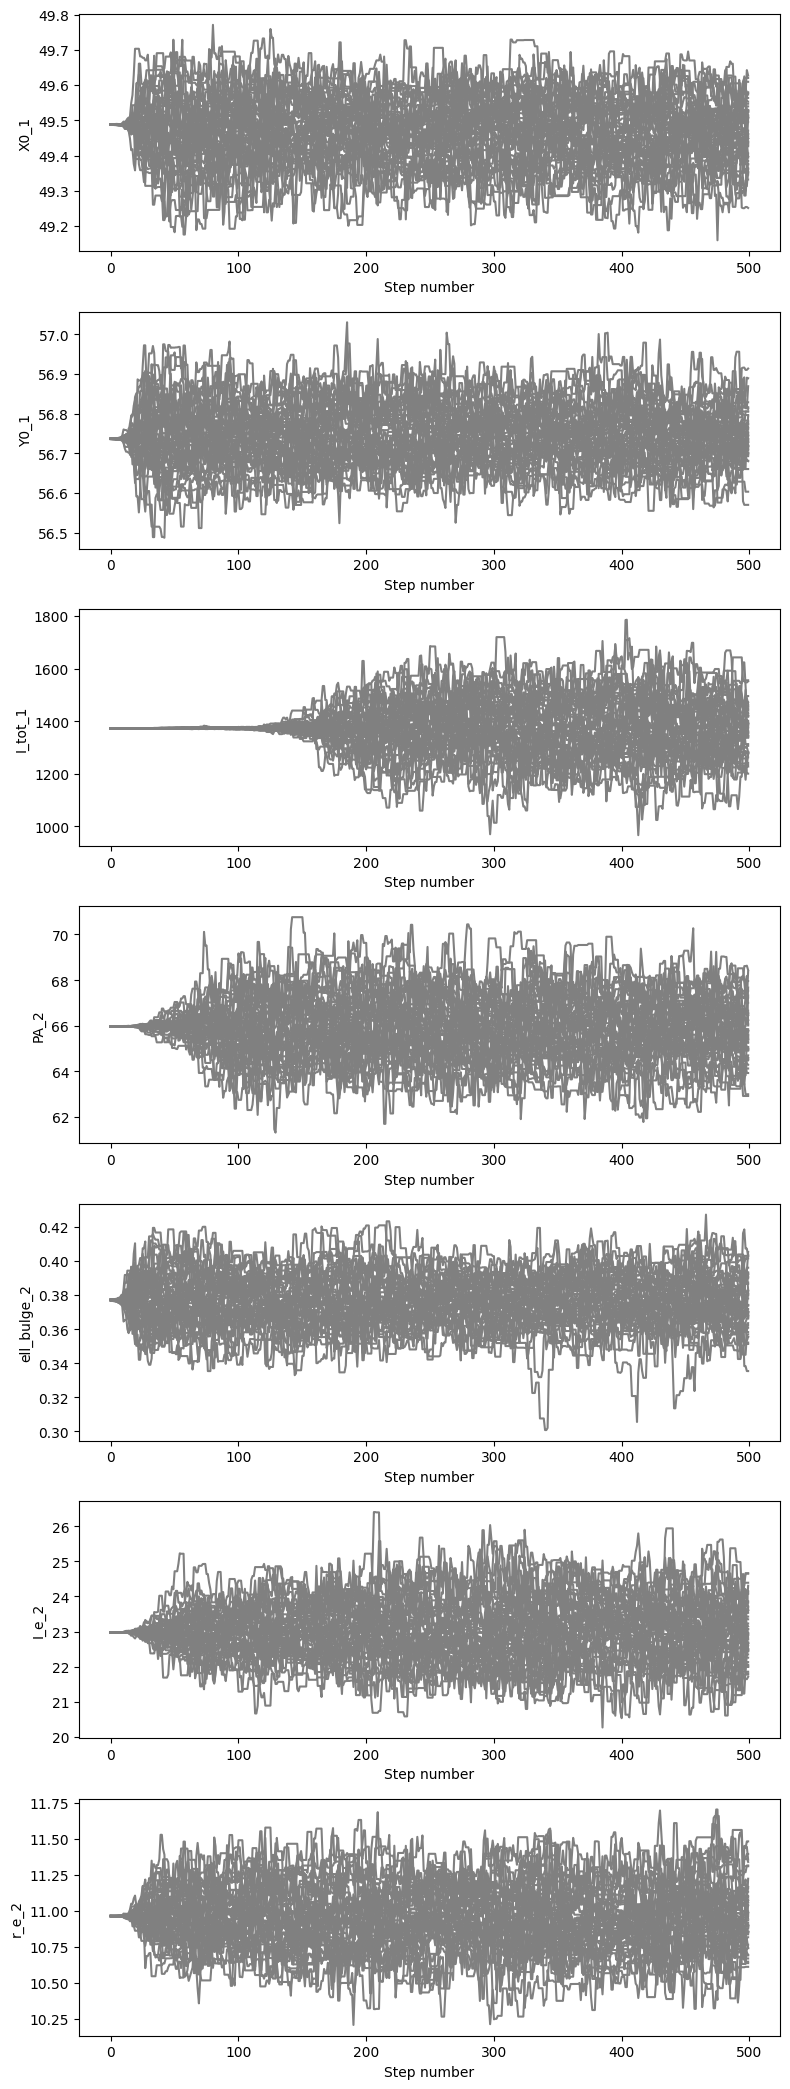

In [75]:
def PlotAllWalkers(sample_chain, yAxisLabel, figtitle):
    n = len(yAxisLabel)
    fig,ax = plt.subplots(n,1,figsize=(8, n*3))
    nWalkers = sample_chain.shape[0]
    for j in range(len(yAxisLabel)):
        for i in range(nWalkers):
            ax[j].plot(sample_chain[i,:,j], color='0.5')
    [ax[i].set_xlabel('Step number') for i in range(len(yAxisLabel))]
    [ax[i].set_ylabel(yAxisLabel[i]) for i in range(len(yAxisLabel))]
    ax[0].set_title(figtitle)
    
    fig.tight_layout();

PlotAllWalkers(sampler.chain, ['X0_1', 'Y0_1', 'I_tot_1', 'PA_2', 'ell_bulge_2', 'I_e_2', 'r_e_2'],"")

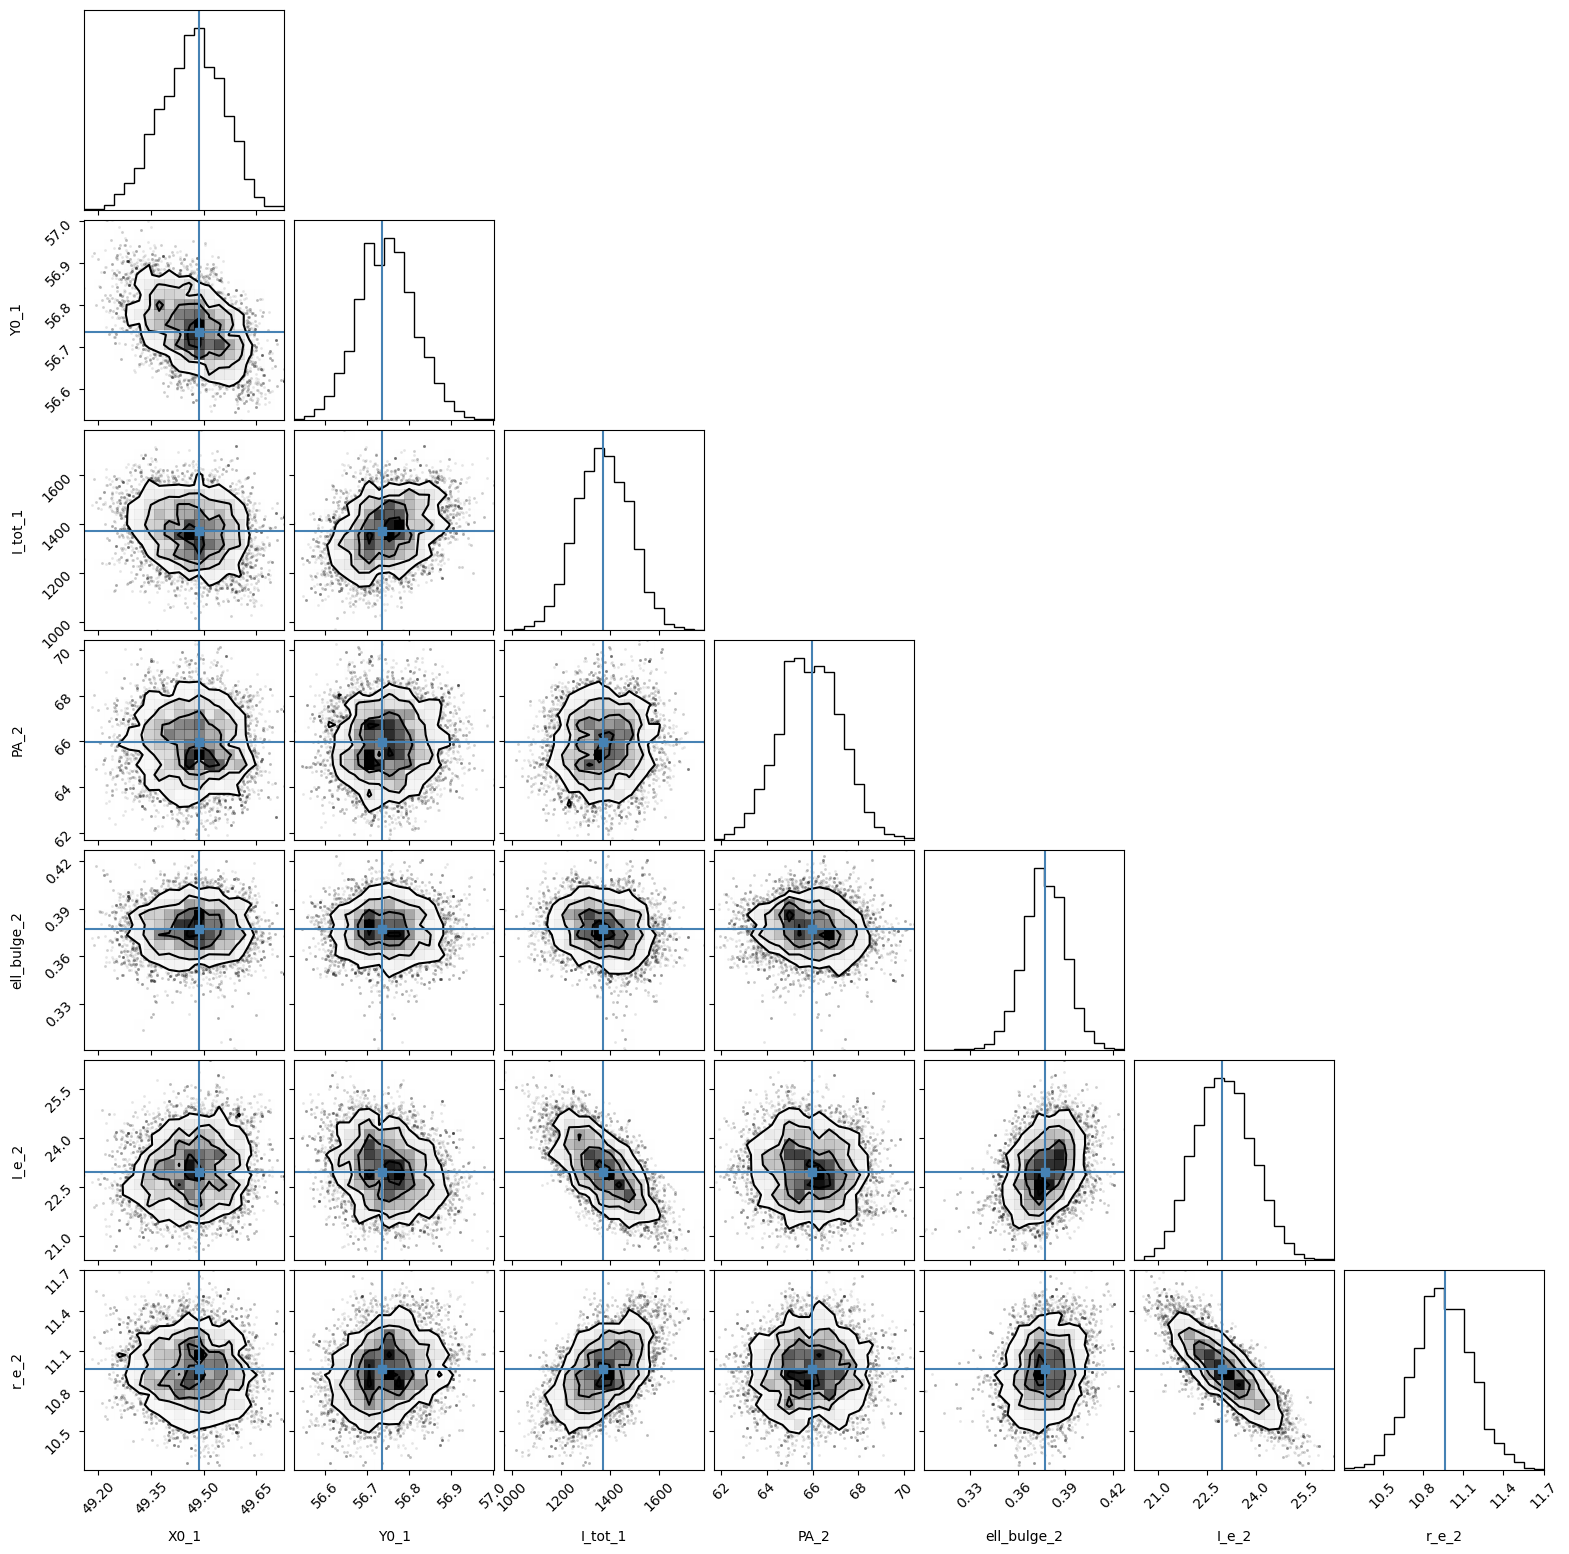

In [77]:
converged_sample = sampler.get_chain(discard=200, flat=True)
fig = corner.corner(converged_sample, truths=p_bestfit,labels=['X0_1', 'Y0_1', 'I_tot_1', 'PA_2', 'ell_bulge_2', 'I_e_2', 'r_e_2'])

In [81]:
labels = ['X0_1', 'Y0_1', 'I_tot_1', 'PA_2', 'ell_bulge_2', 'I_e_2', 'r_e_2']
for i in range(ndims):
    mcmc = np.percentile(converged_sample[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = f'{labels[i]} = {mcmc[1]:.3f} $^{{{q[0]:.3f}}}_{{{q[1]:.3f}}}$'
    display(Latex(txt))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [100]:
mlparams = [np.percentile(converged_sample[:, i], 50) for i in range(ndims)]
mlparams = np.insert(mlFit,5,1)
ml = fitters_n1[0].computeFitStatistic(mlparams)

In [130]:
print(f"BIC: {ndims*np.log(100*100)-ml:.4f}")

BIC: -1574.7301


In [112]:
import pickle
filename = 'sampler_chain.pickle'
# Dump the 'converged_chain' object to the pickle file
with open(filename, 'wb') as file:
    pickle.dump(sampler.chain, file)